# Model 5: Swin Transformer V2

---

**Architecture**
- Swin Transformer V2 (Tiny) - Hierarchical Vision Transformer
- Dual-head output: Pitch + Roll classification
- Pretrained on ImageNet-1K
- Shifted Window Attention mechanism

**Hardware:** Apple M4 + 24GB Unified Memory (MPS)

**Note:** Memory-intensive model - uses smaller batch size (8) and lower learning rate (5e-5)

## 1. Setup & Data Loading


In [ ]:
# Standard libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Timm for Swin Transformer V2
import timm

# Optuna for hyperparameter tuning
import optuna

# Visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# Import dataset
from src.data.pose_dataset import ClassificationDataset

# Import shared utilities (Relevant code in src/utils.py)
from src.utils import (
    # Training
    MetricsTracker,
    train_epoch,
    validate_epoch,
    collect_predictions,
    EarlyStopping,
    # Data
    create_stratified_splits,
    create_dataloaders,
    get_class_mappings,
    # Visualization
    plot_training_curves,
    plot_confusion_matrices,
 
    # Evaluation

    generate_classification_report
)

from src.utils.swin_final_attention import visualize_swin_final_attention

# Set device
# Determine the device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

if device.type == 'mps':
    print("⚠️  WARNING: Swin Transformer V2 is memory-intensive on MPS")
    print("   Using smaller batch size (8) to prevent memory issues")

# Set seeds for reproducibility
torch.manual_seed(42)
import numpy as np
np.random.seed(42)

print("All libraries and utilities imported successfully")


Using device: mps
⚠️  WARNING: Swin Transformer V2 is memory-intensive on MPS
   Using smaller batch size (8) to prevent memory issues
All libraries and utilities imported successfully


### Load Dataset & Create Splits


In [2]:
# Load full dataset
data_root = project_root / 'data'
full_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)

print(f"Total samples: {len(full_dataset)}")
print(f"Pitch classes: {len(full_dataset.p_dict)}")
print(f"Roll classes: {len(full_dataset.r_dict)}")
print(f"\nPitch mapping: {full_dataset.p_dict}")
print(f"Roll mapping: {full_dataset.r_dict}")


Total samples: 2000
Pitch classes: 18
Roll classes: 7

Pitch mapping: {'P0': 0, 'P10': 1, 'P15': 2, 'P25': 3, 'P30': 4, 'P35': 5, 'P40': 6, 'P45': 7, 'P50': 8, 'P55': 9, 'P5': 10, 'P60': 11, 'P65': 12, 'P70': 13, 'P75': 14, 'P80': 15, 'P85': 16, 'P90': 17}
Roll mapping: {'R0': 0, 'R15': 1, 'R30': 2, 'R45': 3, 'R5': 4, 'R10': 5, 'R60': 6}


In [3]:
# Use utility function for stratified splits (REPLACES manual split code)
train_idx, val_idx, test_idx = create_stratified_splits(
    dataset=full_dataset,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=42
)

print(f"\nSplit sizes:")
print(f"   Train: {len(train_idx)} ({len(train_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Val:   {len(val_idx)} ({len(val_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Test:  {len(test_idx)} ({len(test_idx)/len(full_dataset)*100:.1f}%)")



Split sizes:
   Train: 1200 (60.0%)
   Val:   400 (20.0%)
   Test:  400 (20.0%)


In [4]:
# Create dataset splits with augmentation for training
train_dataset = ClassificationDataset(rootpath=str(data_root), augment=True, random_ratio=0.5)
val_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)
test_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)

# Use utility function for dataloader creation (REPLACES manual DataLoader code)
# SMALLER BATCH SIZE for Swin Transformer (memory constraints)
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    train_indices=train_idx,
    val_indices=val_idx,
    test_indices=test_idx,
    batch_size=8,  # Reduced from 64 for transformers
    num_workers=0,  # MPS-optimized
    pin_memory=False  # MPS-optimized
)

# Get class mappings (NEW utility function)
mappings = get_class_mappings(full_dataset)

print("Datasets and loaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")
print(f"   Pitch classes: {mappings['num_pitch_classes']}")
print(f"   Roll classes: {mappings['num_roll_classes']}")


Datasets and loaders created
   Train batches: 150
   Val batches: 50
   Test batches: 50
   Pitch classes: 18
   Roll classes: 7


In [5]:
# IMPORTANT: Swin-V2 requires 256x256 images, but dataset provides 224x224
# We need to add a resize transform to the test

# Create a wrapper that resizes images from 224 to 256
import torchvision.transforms as T

resize_transform = T.Resize((256, 256))

# Wrap the dataloaders to resize on-the-fly
class ResizingDataLoader:
    """Wrapper that resizes images from 224x224 to 256x256"""
    def __init__(self, dataloader, target_size=256):
        self.dataloader = dataloader
        self.resize = T.Resize((target_size, target_size))
    
    def __iter__(self):
        for images, labels in self.dataloader:
            # Resize images from 224x224 to 256x256
            images = self.resize(images)
            yield images, labels
    
    def __len__(self):
        return len(self.dataloader)

# Wrap all dataloaders
train_loader = ResizingDataLoader(train_loader, target_size=256)
val_loader = ResizingDataLoader(val_loader, target_size=256)
test_loader = ResizingDataLoader(test_loader, target_size=256)

print("✅ Dataloaders wrapped to resize 224x224 → 256x256 for Swin-V2")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

✅ Dataloaders wrapped to resize 224x224 → 256x256 for Swin-V2
   Train batches: 150
   Val batches: 50
   Test batches: 50


## 2. Model Architecture

**Swin Transformer V2 Design:**
- Hierarchical vision transformer with shifted windows
- Pretrained backbone: `swinv2_tiny_window8_256.ms_in1k`
- Feature dimension: 768
- Dual classification heads (pitch + roll)
- More efficient than standard ViT through local attention

**Key Differences from CNN:**
- Self-attention instead of convolution
- Patch-based processing
- Position-relative biases
- Hierarchical feature maps


In [6]:
class SwinTransformerV2DualHead(nn.Module):
    """
    Swin Transformer V2 for dual-head pose classification
    
    Uses swinv2_tiny_window16_256 which requires 256x256 images
    """
    
    def __init__(
        self,
        num_pitch_classes=18,
        num_roll_classes=7,
        pretrained=True,
        dropout_rate=0.3,
        img_size=256,  #  MUST be 256 for this model
        window_size=16  # Native window size for this variant
    ):
        super(SwinTransformerV2DualHead, self).__init__()
        
        # swinv2_tiny_window16_256 works natively with 256x256 images
        model_name = 'swinv2_tiny_window16_256.ms_in1k'
        
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove classification head
            img_size=img_size
        )
        
        # Get feature dimension from backbone
        self.feature_dim = self.backbone.num_features  # 768 for tiny
        
        # Dual classification heads with dropout
        self.pitch_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, num_pitch_classes)
        )
        
        self.roll_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, num_roll_classes)
        )
        
        # Initialize classification heads
        self._init_weights()
    
    def _init_weights(self):
        """Initialize classification head weights"""
        for head in [self.pitch_head, self.roll_head]:
            for m in head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.trunc_normal_(m.weight, std=0.02)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
    
    def forward(self, x, return_features=False):
        """Forward pass"""
        # Extract features from backbone
        features = self.backbone(x)  # (B, 768)
        
        # Dual classification heads
        pitch_logits = self.pitch_head(features)
        roll_logits = self.roll_head(features)
        
        if return_features:
            return pitch_logits, roll_logits, features
        
        return pitch_logits, roll_logits
    
    def get_attention_weights(self, x, layer_idx=-1):
        """Extract attention weights from specified layer"""
        self.backbone.eval()
        with torch.no_grad():
            features = self.backbone(x)
        return features


# Test model
try:
    print("Testing Swin-V2 model initialization...")
    test_model = SwinTransformerV2DualHead(pretrained=False)
    test_input = torch.randn(1, 3, 256, 256)  # ✅ Changed to 256
    pitch_out, roll_out = test_model(test_input)
    print(f"✓ Model test passed!")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Pitch output: {pitch_out.shape}")
    print(f"  Roll output: {roll_out.shape}")
    print(f"  Feature dim: {test_model.feature_dim}")
    del test_model, test_input
except Exception as e:
    print(f"✗ Model test failed: {e}")
    import traceback
    traceback.print_exc()

Testing Swin-V2 model initialization...
✓ Model test passed!
  Input shape: torch.Size([1, 3, 256, 256])
  Pitch output: torch.Size([1, 18])
  Roll output: torch.Size([1, 7])
  Feature dim: 768


## 3. Training (Baseline)

First training run with default hyperparameters to establish baseline performance.

**Transformer-specific settings:**
- Lower learning rate (5e-5 vs 1e-3 for CNN)
- Smaller batch size (8 vs 64)
- Longer warm-up period


In [7]:
print("Just to remember: Training utilities ready (imported from src.utils)")

print("   - MetricsTracker: Track metrics across epochs")
print("   - train_epoch(): Train for one epoch")
print("   - validate_epoch(): Validate for one epoch")
print("   - EarlyStopping: Prevent overfitting")
print("   - collect_predictions(): Get all predictions")


Just to remember: Training utilities ready (imported from src.utils)
   - MetricsTracker: Track metrics across epochs
   - train_epoch(): Train for one epoch
   - validate_epoch(): Validate for one epoch
   - EarlyStopping: Prevent overfitting
   - collect_predictions(): Get all predictions


In [8]:
# Baseline hyperparameters (TRANSFORMER-OPTIMIZED)
BASELINE_CONFIG = {
    'batch_size': 8,  # Smaller for transformers
    'lr': 5e-5,  # Lower learning rate
    'epochs': 20,
    'dropout_rate': 0.3,
    'weight_decay': 1e-4,
    'img_size': 256,  # ✅ Changed to 256 - REQUIRED for swinv2_tiny_window16_256
    'window_size': 16  # Window size 16 (native for this model)
}

# Data loaders already created using create_dataloaders() utility in cell 6!
# No need to create them again here

print(f"Baseline configuration set (Transformer-optimized)")
print(f"   Batch size: {BASELINE_CONFIG['batch_size']} (reduced for memory)")
print(f"   Learning rate: {BASELINE_CONFIG['lr']} (lower for pretrained model)")
print(f"   Epochs: {BASELINE_CONFIG['epochs']}")
print(f"   Image size: {BASELINE_CONFIG['img_size']}x{BASELINE_CONFIG['img_size']}")
print(f"   Window size: {BASELINE_CONFIG['window_size']}x{BASELINE_CONFIG['window_size']}")
print(f"   Using 256x256 images (required for swinv2_tiny_window16_256)")

Baseline configuration set (Transformer-optimized)
   Batch size: 8 (reduced for memory)
   Learning rate: 5e-05 (lower for pretrained model)
   Epochs: 20
   Image size: 256x256
   Window size: 16x16
   Using 256x256 images (required for swinv2_tiny_window16_256)


In [9]:
# Initialize baseline model
baseline_model = SwinTransformerV2DualHead(
    num_pitch_classes=len(full_dataset.p_dict),
    num_roll_classes=len(full_dataset.r_dict),
    pretrained=True,
    img_size=BASELINE_CONFIG['img_size'],
    window_size=BASELINE_CONFIG['window_size'],
    dropout_rate=BASELINE_CONFIG['dropout_rate']
).to(device)

# Loss functions
criterion_pitch = nn.CrossEntropyLoss()
criterion_roll = nn.CrossEntropyLoss()

# Optimizer (AdamW with higher weight decay for transformers)
optimizer = torch.optim.AdamW(
    baseline_model.parameters(),
    lr=BASELINE_CONFIG['lr'],
    weight_decay=BASELINE_CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10)

# Metrics tracker
baseline_tracker = MetricsTracker()

print(f"Baseline Swin Transformer V2 model initialized")
print(f"   Pretrained: ImageNet-1K")
print(f"   Window size: {BASELINE_CONFIG['window_size']}")
print(f"   Image size: {BASELINE_CONFIG['img_size']}")
print(f"   Device: {device}")
print(f"⚠️  Memory usage will be high - monitor MPS allocation")

Baseline Swin Transformer V2 model initialized
   Pretrained: ImageNet-1K
   Window size: 16
   Image size: 256
   Device: mps
⚠️  Memory usage will be high - monitor MPS allocation


### Training


In [ ]:
# Training loop
print("Baseline training\n")

best_val_acc = 0
patience = 20
patience_counter = 0

for epoch in range(1, BASELINE_CONFIG['epochs'] + 1):
    # Train
    train_metrics = train_epoch(
        baseline_model, train_loader,
        criterion_pitch, criterion_roll,
        optimizer, device
    )
    
    # Validate
    val_metrics = validate_epoch(
        baseline_model, val_loader,
        criterion_pitch, criterion_roll,
        device
    )
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Track metrics
    baseline_tracker.update({
        'train_loss': train_metrics['loss'],
        'train_pitch_loss': train_metrics['pitch_loss'],
        'train_roll_loss': train_metrics['roll_loss'],
        'train_pitch_acc': train_metrics['pitch_acc'],
        'train_roll_acc': train_metrics['roll_acc'],
        'val_loss': val_metrics['loss'],
        'val_pitch_loss': val_metrics['pitch_loss'],
        'val_roll_loss': val_metrics['roll_loss'],
        'val_pitch_acc': val_metrics['pitch_acc'],
        'val_roll_acc': val_metrics['roll_acc'],
        'lr': current_lr
    })
    
    # Save best model
    val_acc_avg = (val_metrics['pitch_acc'] + val_metrics['roll_acc']) / 2
    if val_acc_avg > best_val_acc:
        best_val_acc = val_acc_avg
        torch.save(baseline_model.state_dict(), project_root / 'models' / '4_swin_v2.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{BASELINE_CONFIG['epochs']}")
        print(f"  Train - Loss: {train_metrics['loss']:.4f} | "
              f"Pitch Acc: {train_metrics['pitch_acc']:.3f} | "
              f"Roll Acc: {train_metrics['roll_acc']:.3f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f} | "
              f"Pitch Acc: {val_metrics['pitch_acc']:.3f} | "
              f"Roll Acc: {val_metrics['roll_acc']:.3f}")
        print(f"  LR: {current_lr:.6f}\n")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"⏹ Early stopping triggered at epoch {epoch}")
        break

print(f"\n✅ Baseline training completed")
print(f"   Best validation accuracy: {best_val_acc:.4f}")


Baseline training

Epoch 01/20
  Train - Loss: 3.1773 | Pitch Acc: 0.282 | Roll Acc: 0.608
  Val   - Loss: 1.7649 | Pitch Acc: 0.588 | Roll Acc: 0.797
  LR: 0.000049

Epoch 05/20
  Train - Loss: 0.3489 | Pitch Acc: 0.936 | Roll Acc: 0.963
  Val   - Loss: 0.2417 | Pitch Acc: 0.960 | Roll Acc: 0.963
  LR: 0.000025

Epoch 10/20
  Train - Loss: 0.1007 | Pitch Acc: 0.995 | Roll Acc: 0.994
  Val   - Loss: 0.0994 | Pitch Acc: 0.983 | Roll Acc: 0.983
  LR: 0.000050

Epoch 15/20
  Train - Loss: 0.0865 | Pitch Acc: 0.992 | Roll Acc: 0.990
  Val   - Loss: 0.0726 | Pitch Acc: 0.990 | Roll Acc: 0.985
  LR: 0.000025

Epoch 20/20
  Train - Loss: 0.0296 | Pitch Acc: 0.998 | Roll Acc: 0.999
  Val   - Loss: 0.0375 | Pitch Acc: 0.995 | Roll Acc: 0.993
  LR: 0.000050


✅ Baseline training completed
   Best validation accuracy: 0.9938


In [ ]:
torch.save(baseline_model.state_dict(), project_root / 'models' / '4_swin_v2.pth')

In [ ]:
baseline_model.load_state_dict(torch.load(project_root / 'models' / '4_swin_v2.pth'))
baseline_model.eval()


SwinTransformerV2DualHead(
  (backbone): SwinTransformerV2(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerV2Stage(
        (downsample): Identity()
        (blocks): ModuleList(
          (0): SwinTransformerV2Block(
            (attn): WindowAttention(
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=3, bias=False)
              )
              (qkv): Linear(in_features=96, out_features=288, bias=False)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (norm1)

## 4. Evaluation & Error Analysis

Comprehensive analysis of baseline model performance.


### 4.1 Training Dynamics Visualization


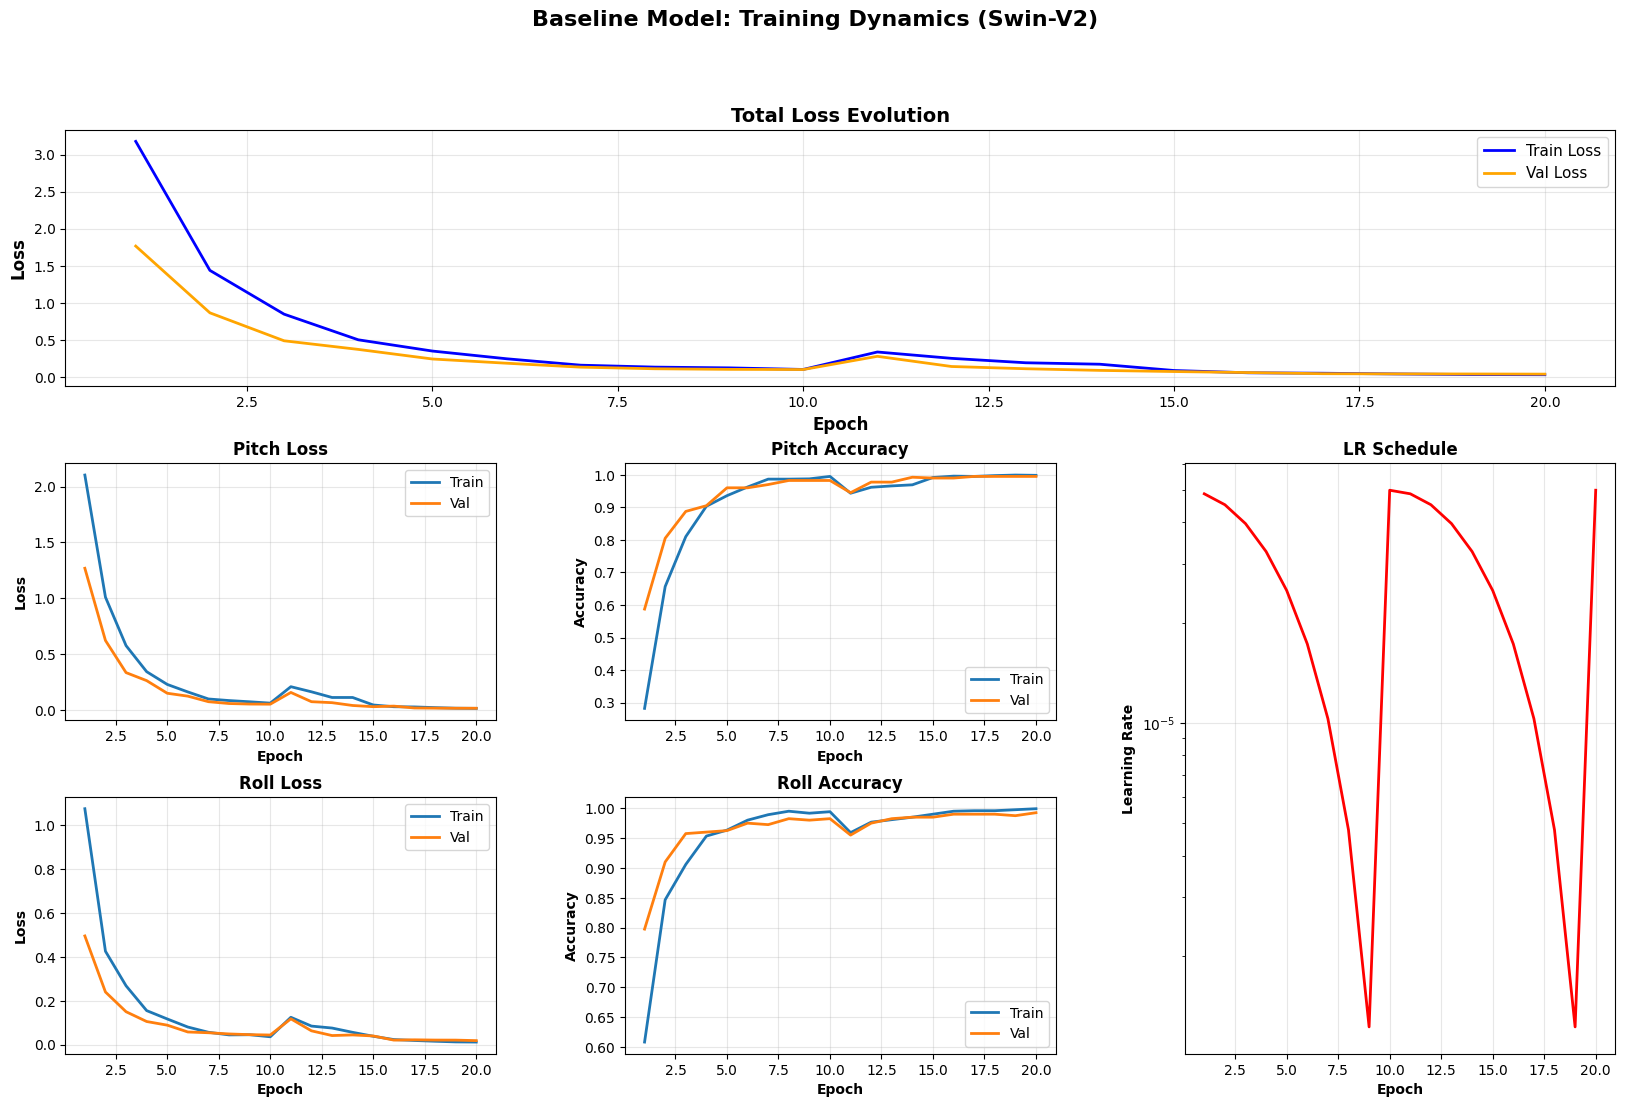

In [13]:
plot_training_curves(
    tracker_history=baseline_tracker.history,
    save_path=project_root / 'reports' / '5_swin_v2_training_curves.png',
    title='Baseline Model: Training Dynamics (Swin-V2)'
)


### 4.2 Test Set Evaluation


In [ ]:
# Load best model
baseline_model.load_state_dict(torch.load(project_root / 'models' / '4_swin_v2.pth'))
baseline_model.eval()

# Evaluate on test set
test_metrics = validate_epoch(
    baseline_model, test_loader,
    criterion_pitch, criterion_roll,
    device
)

print("Test Set Performance:")
print(f"   Loss: {test_metrics['loss']:.4f}")
print(f"   Pitch Accuracy: {test_metrics['pitch_acc']:.4f}")
print(f"   Roll Accuracy: {test_metrics['roll_acc']:.4f}")
print(f"   Average Accuracy: {(test_metrics['pitch_acc'] + test_metrics['roll_acc'])/2:.4f}")


Test Set Performance:
   Loss: 0.0368
   Pitch Accuracy: 0.9950
   Roll Accuracy: 0.9975
   Average Accuracy: 0.9963


In [10]:
test_predictions = collect_predictions(
    model=baseline_model,
    dataloader=test_loader,
    device=device
)

print("Predictions collected using collect_predictions() utility")
print(f"   Pitch predictions shape: {test_predictions['pitch_preds'].shape}")
print(f"   Roll predictions shape: {test_predictions['roll_preds'].shape}")


Predictions collected using collect_predictions() utility
   Pitch predictions shape: (400,)
   Roll predictions shape: (400,)


### 4.3 Confusion Matrices


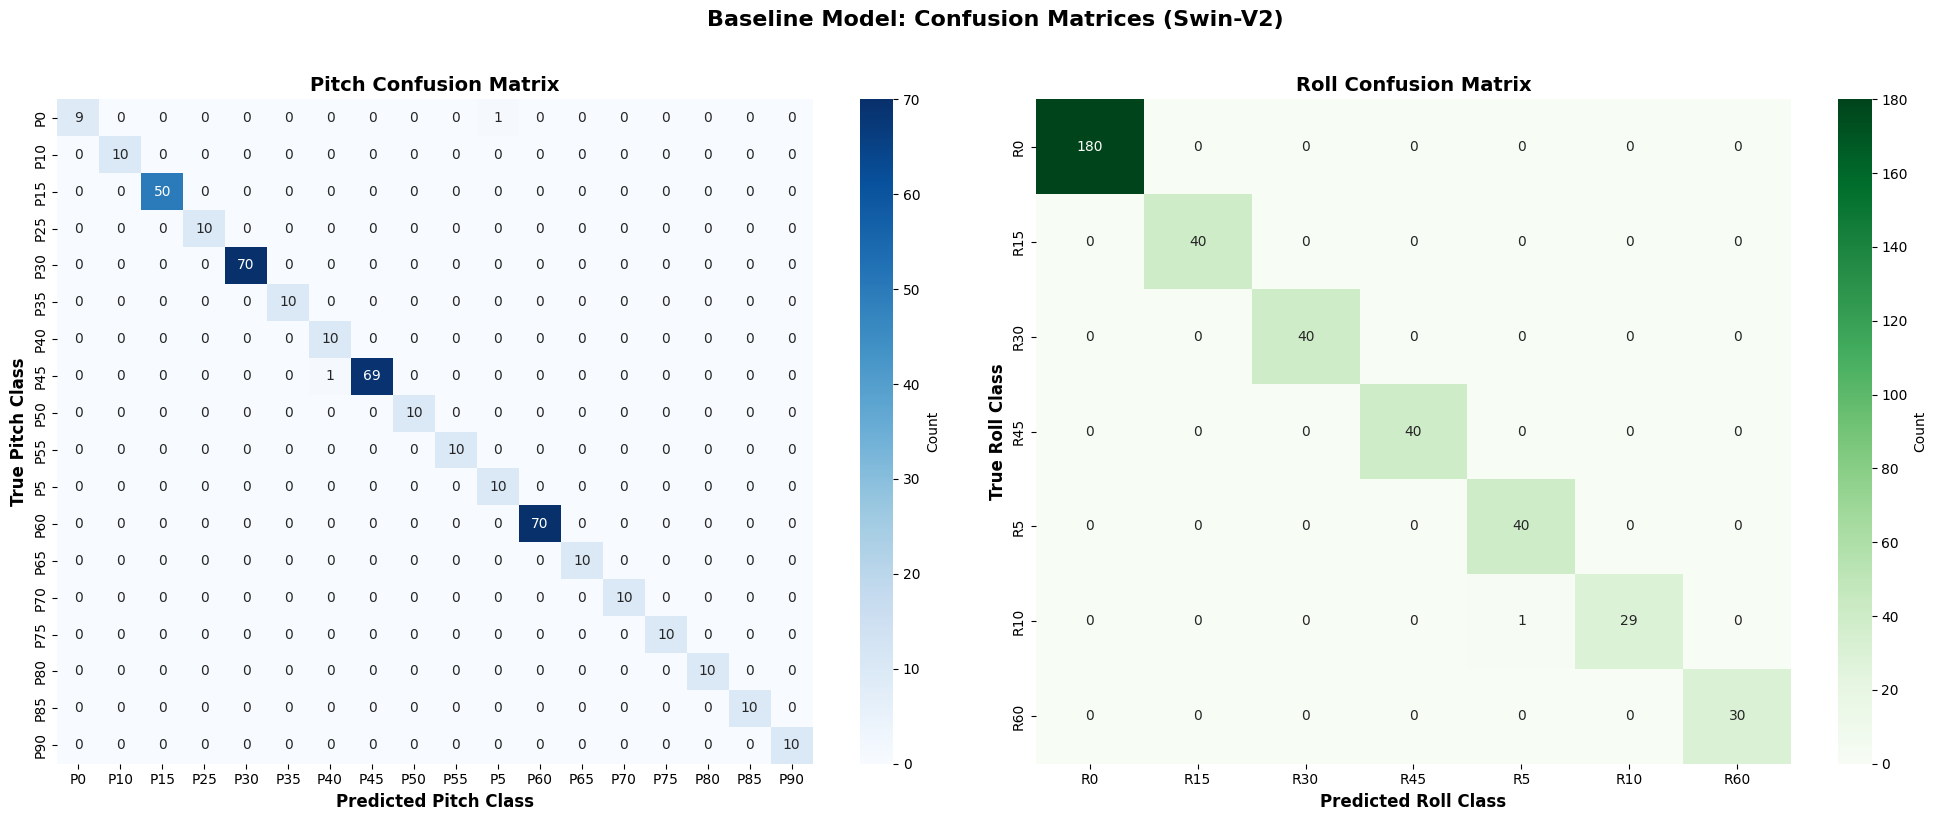

In [ ]:

pitch_names = [mappings['pitch_inv'][i] for i in range(mappings['num_pitch_classes'])]
roll_names = [mappings['roll_inv'][i] for i in range(mappings['num_roll_classes'])]

plot_confusion_matrices(
    predictions=test_predictions,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names,
    save_path=project_root / 'reports' / '5_swin_v2_confusion_matrices.png',
    title='Baseline Model: Confusion Matrices (Swin-V2)'
)

### 4.4 Per-Class Performance Analysis


In [ ]:
# Use utility function for classification reports (REPLACES manual reporting)
pitch_report, roll_report = generate_classification_report(
    predictions=test_predictions,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names
)

print("Pitch Classification Report:")
print(pitch_report)

print("\nRoll Classification Report:")
print(roll_report)


### Model: Additional Visualizations


### 7.1 Systematic Error Analysis


In [12]:
# Use analyze_errors utility to identify systematic misclassification patterns
from src.utils import analyze_errors

error_analysis = analyze_errors(
    predictions=test_predictions,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names,
    top_k=10
)

print("="*70)
print("SYSTEMATIC ERROR ANALYSIS")
print("="*70)

print(f"\n📊 Overall Error Rates:")
print(f"   Pitch Error Rate: {error_analysis['pitch_error_rate']*100:.2f}%")
print(f"   Roll Error Rate: {error_analysis['roll_error_rate']*100:.2f}%")
print(f"   Total Misclassified (Pitch): {len(error_analysis['pitch_error_indices'])}/{len(test_predictions['pitch_labels'])}")
print(f"   Total Misclassified (Roll): {len(error_analysis['roll_error_indices'])}/{len(test_predictions['roll_labels'])}")

print(f"\n🔀 Top 10 Most Confused Pitch Class Pairs:")
for i, pair in enumerate(error_analysis['pitch_confusion_pairs'][:10], 1):
    print(f"   {i}. {pair['true_class']} → {pair['pred_class']}: {pair['count']} errors")

print(f"\n🔀 Top 10 Most Confused Roll Class Pairs:")
for i, pair in enumerate(error_analysis['roll_confusion_pairs'][:10], 1):
    print(f"   {i}. {pair['true_class']} → {pair['pred_class']}: {pair['count']} errors")


SYSTEMATIC ERROR ANALYSIS

📊 Overall Error Rates:
   Pitch Error Rate: 0.50%
   Roll Error Rate: 0.25%
   Total Misclassified (Pitch): 2/400
   Total Misclassified (Roll): 1/400

🔀 Top 10 Most Confused Pitch Class Pairs:
   1. P0 → P5: 1 errors
   2. P45 → P40: 1 errors

🔀 Top 10 Most Confused Roll Class Pairs:
   1. R10 → R5: 1 errors


### 7.2 Worst Predictions Gallery


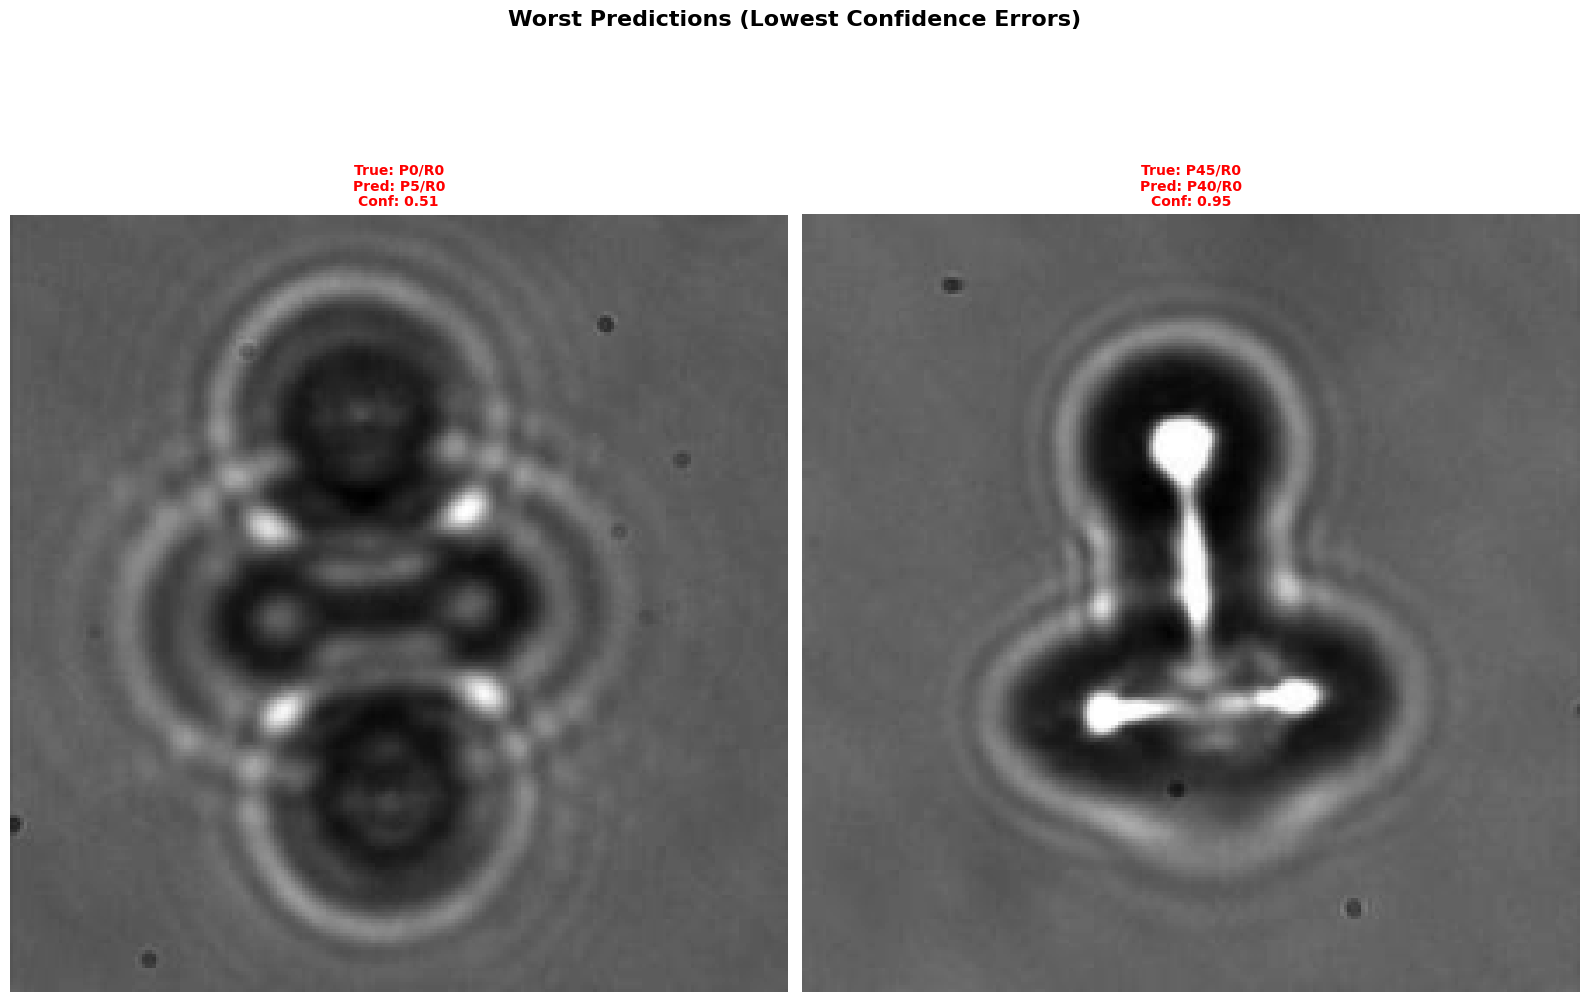


🖼️  Worst predictions gallery created (2 samples)


In [13]:
# Visualize worst predictions (lowest confidence + incorrect)
incorrect_pitch = test_predictions['pitch_preds'] != test_predictions['pitch_labels']
incorrect_pitch_indices = np.where(incorrect_pitch)[0]

if len(incorrect_pitch_indices) > 0:
    # Get confidence scores for incorrect predictions
    incorrect_confidences = test_predictions['pitch_probs'][incorrect_pitch_indices].max(axis=1)
    
    # Sort by confidence (lowest first = worst predictions)
    worst_indices = incorrect_pitch_indices[np.argsort(incorrect_confidences)[:9]]
    
    # Create gallery
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(worst_indices):
        # Get image from test dataset
        img, (pitch_label, roll_label) = test_dataset[test_idx[idx]]
        
        # Denormalize image for display
        img_display = img.permute(1, 2, 0).numpy()
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
        
        # Get predictions
        true_pitch = pitch_names[test_predictions['pitch_labels'][idx]]
        pred_pitch = pitch_names[test_predictions['pitch_preds'][idx]]
        true_roll = roll_names[test_predictions['roll_labels'][idx]]
        pred_roll = roll_names[test_predictions['roll_preds'][idx]]
        conf = test_predictions['pitch_probs'][idx].max()
        
        # Display
        axes[i].imshow(img_display)
        axes[i].axis('off')
        
        # Title with true vs predicted
        title = f"True: {true_pitch}/{true_roll}\nPred: {pred_pitch}/{pred_roll}\nConf: {conf:.2f}"
        axes[i].set_title(title, fontsize=10, color='red', fontweight='bold')
    
    plt.suptitle('Worst Predictions (Lowest Confidence Errors)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / '5_swin_v2_worst_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n🖼️  Worst predictions gallery created ({len(worst_indices)} samples)")
else:
    print("No incorrect predictions found!")


### 7.4 Attention Maps Visualization (Transformer Stages)

**Transformer-specific:** Unlike CNNs with feature maps, we visualize attention patterns from different Swin Transformer stages.


Sample #0:
  True: Pitch=P30, Roll=R5
  Pred: Pitch=P30, Roll=R5


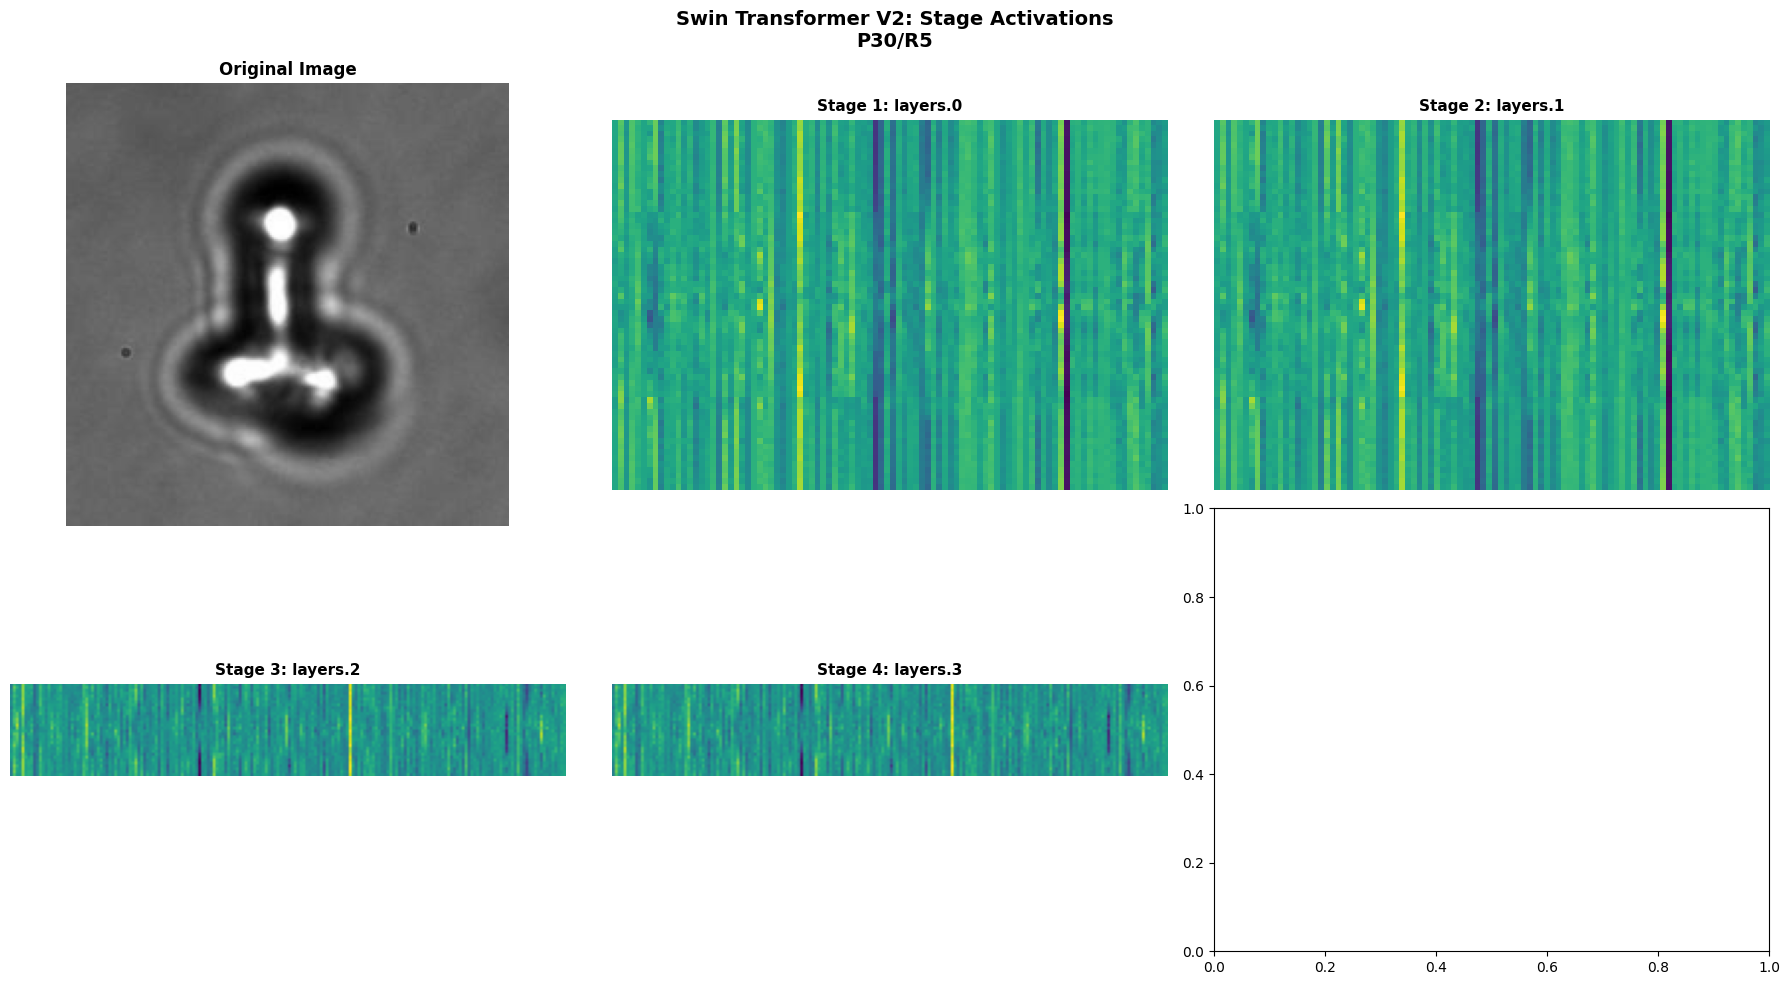


 Attention maps visualization created for 8 stages


In [15]:
# Visualize attention patterns from Swin Transformer V2
# Note: This is adapted for transformers - we extract intermediate features from different stages

# Select a sample image from test set
sample_idx = 0
sample_img, (sample_pitch, sample_roll) = test_dataset[test_idx[sample_idx]]
sample_img_batch = sample_img.unsqueeze(0).to(device)

#  Force resize to model size
sample_img_batch = torch.nn.functional.interpolate(
    sample_img_batch,
    size=(256, 256),
    mode="bilinear",
    align_corners=False
)

# Get true and predicted labels
true_pitch_name = pitch_names[test_predictions['pitch_labels'][sample_idx]]
pred_pitch_name = pitch_names[test_predictions['pitch_preds'][sample_idx]]
true_roll_name = roll_names[test_predictions['roll_labels'][sample_idx]]
pred_roll_name = roll_names[test_predictions['roll_preds'][sample_idx]]

print(f"Sample #{sample_idx}:")
print(f"  True: Pitch={true_pitch_name}, Roll={true_roll_name}")
print(f"  Pred: Pitch={pred_pitch_name}, Roll={pred_roll_name}")

# Extract intermediate features from Swin Transformer stages
activations = []

def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

# Register hooks for different stages
# Swin-V2 has 4 stages with different spatial resolutions
hooks = []
stage_names = ['layers.0', 'layers.1', 'layers.2', 'layers.3']

for stage_name in stage_names:
    try:
        layer = dict(baseline_model.backbone.named_modules())[stage_name]
        hooks.append(layer.register_forward_hook(get_activation(stage_name)))
    except:
        pass

# Forward pass
with torch.no_grad():
    _ = baseline_model(sample_img_batch)

# Remove hooks
for hook in hooks:
    hook.remove()

# Visualize stage outputs
if len(activations) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    # Original image
    img_display = sample_img.permute(1, 2, 0).numpy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    axes[0].imshow(img_display)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Visualize each stage
    for i, (act, stage_name) in enumerate(zip(activations[:5], stage_names[:5])):
        # Swin outputs are [B, H*W, C], need to reshape
        if len(act.shape) == 3:
            # Average across channels
            act_map = act[0].mean(dim=-1)  # [H*W]
            # Reshape to 2D (approximate square)
            size = int(np.sqrt(act_map.shape[0]))
            if size * size == act_map.shape[0]:
                act_map = act_map.reshape(size, size)
            else:
                # Handle non-square case
                act_map = act_map[:size*size].reshape(size, size)
        else:
            # If already spatial, average across channels
            act_map = act[0].mean(dim=0)
        
        # Normalize
        act_map = act_map.cpu().numpy()
        act_map = (act_map - act_map.min()) / (act_map.max() - act_map.min() + 1e-8)
        
        # Display
        axes[i+1].imshow(act_map, cmap='viridis')
        axes[i+1].set_title(f'Stage {i+1}: {stage_name}', fontsize=11, fontweight='bold')
        axes[i+1].axis('off')
    
    plt.suptitle(f'Swin Transformer V2: Stage Activations\n{true_pitch_name}/{true_roll_name}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / '5_swin_v2_attention_maps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n Attention maps visualization created for {len(activations)} stages")
else:
    print("Could not extract stage activations")


### 7.5 Grad-CAM Attention Heatmaps


In [29]:
from src.utils.swin_stage4_attention import visualize_swin_stage4_attention

In [31]:
print("\n--- ALL MODULES CONTAINING 'attn' ---\n")

for name, module in baseline_model.named_modules():
    if "attn" in name.lower():
        print(name, "→", type(module))



--- ALL MODULES CONTAINING 'attn' ---

backbone.layers.0.blocks.0.attn → <class 'timm.models.swin_transformer_v2.WindowAttention'>
backbone.layers.0.blocks.0.attn.cpb_mlp → <class 'torch.nn.modules.container.Sequential'>
backbone.layers.0.blocks.0.attn.cpb_mlp.0 → <class 'torch.nn.modules.linear.Linear'>
backbone.layers.0.blocks.0.attn.cpb_mlp.1 → <class 'torch.nn.modules.activation.ReLU'>
backbone.layers.0.blocks.0.attn.cpb_mlp.2 → <class 'torch.nn.modules.linear.Linear'>
backbone.layers.0.blocks.0.attn.qkv → <class 'torch.nn.modules.linear.Linear'>
backbone.layers.0.blocks.0.attn.attn_drop → <class 'torch.nn.modules.dropout.Dropout'>
backbone.layers.0.blocks.0.attn.proj → <class 'torch.nn.modules.linear.Linear'>
backbone.layers.0.blocks.0.attn.proj_drop → <class 'torch.nn.modules.dropout.Dropout'>
backbone.layers.0.blocks.0.attn.softmax → <class 'torch.nn.modules.activation.Softmax'>
backbone.layers.0.blocks.1.attn → <class 'timm.models.swin_transformer_v2.WindowAttention'>
backbone

In [33]:
from src.utils.swin_final_attention import visualize_swin_final_attention

n_samples = 6
print(f"Generating FINAL Swin-V2 attention maps for {n_samples} samples...")

for i in range(n_samples):

    sample_img, _ = test_dataset[test_idx[i]]
    sample_img_batch = sample_img.unsqueeze(0).to(device)

    sample_img_batch = torch.nn.functional.interpolate(
        sample_img_batch,
        size=(256, 256),
        mode="bilinear",
        align_corners=False
    )

    true_pitch = pitch_names[test_predictions['pitch_labels'][i]]
    true_roll  = roll_names[test_predictions['roll_labels'][i]]
    pred_pitch = pitch_names[test_predictions['pitch_preds'][i]]
    pred_roll  = roll_names[test_predictions['roll_preds'][i]]
    conf = test_predictions['pitch_probs'][i].max()

    print(
        f"Sample {i+1}: "
        f"True={true_pitch}/{true_roll}, "
        f"Pred={pred_pitch}/{pred_roll}, "
        f"Conf={conf:.3f}"
    )

    try:
        visualize_swin_final_attention(
            model=baseline_model,
            image_tensor=sample_img_batch,
            save_path=project_root / "reports" / f"5_swin_v2_FINAL_attention_{i}.png"
        )

    except Exception as e:
        print(f"Attention failed for sample {i}: {e}")


Generating FINAL Swin-V2 attention maps for 6 samples...
Sample 1: True=P30/R5, Pred=P30/R5, Conf=0.997
Hook registered on: backbone.layers.3.blocks.1.attn.softmax


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000059604646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000059604646].


Sample 2: True=P60/R0, Pred=P60/R0, Conf=0.999
Hook registered on: backbone.layers.3.blocks.1.attn.softmax
Sample 3: True=P90/R0, Pred=P90/R0, Conf=0.999
Hook registered on: backbone.layers.3.blocks.1.attn.softmax
Sample 4: True=P45/R5, Pred=P45/R5, Conf=1.000
Hook registered on: backbone.layers.3.blocks.1.attn.softmax


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01557940524071455..1.0000000059604646].


Sample 5: True=P40/R0, Pred=P40/R0, Conf=0.999
Hook registered on: backbone.layers.3.blocks.1.attn.softmax
Sample 6: True=P15/R0, Pred=P15/R0, Conf=0.982
Hook registered on: backbone.layers.3.blocks.1.attn.softmax


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000059604646].


### 7.7 Embedding Space Visualization (t-SNE)


Extracting learned feature embeddings...
Embeddings shape: (400, 768)
Number of samples: 400
Feature dimension: 768


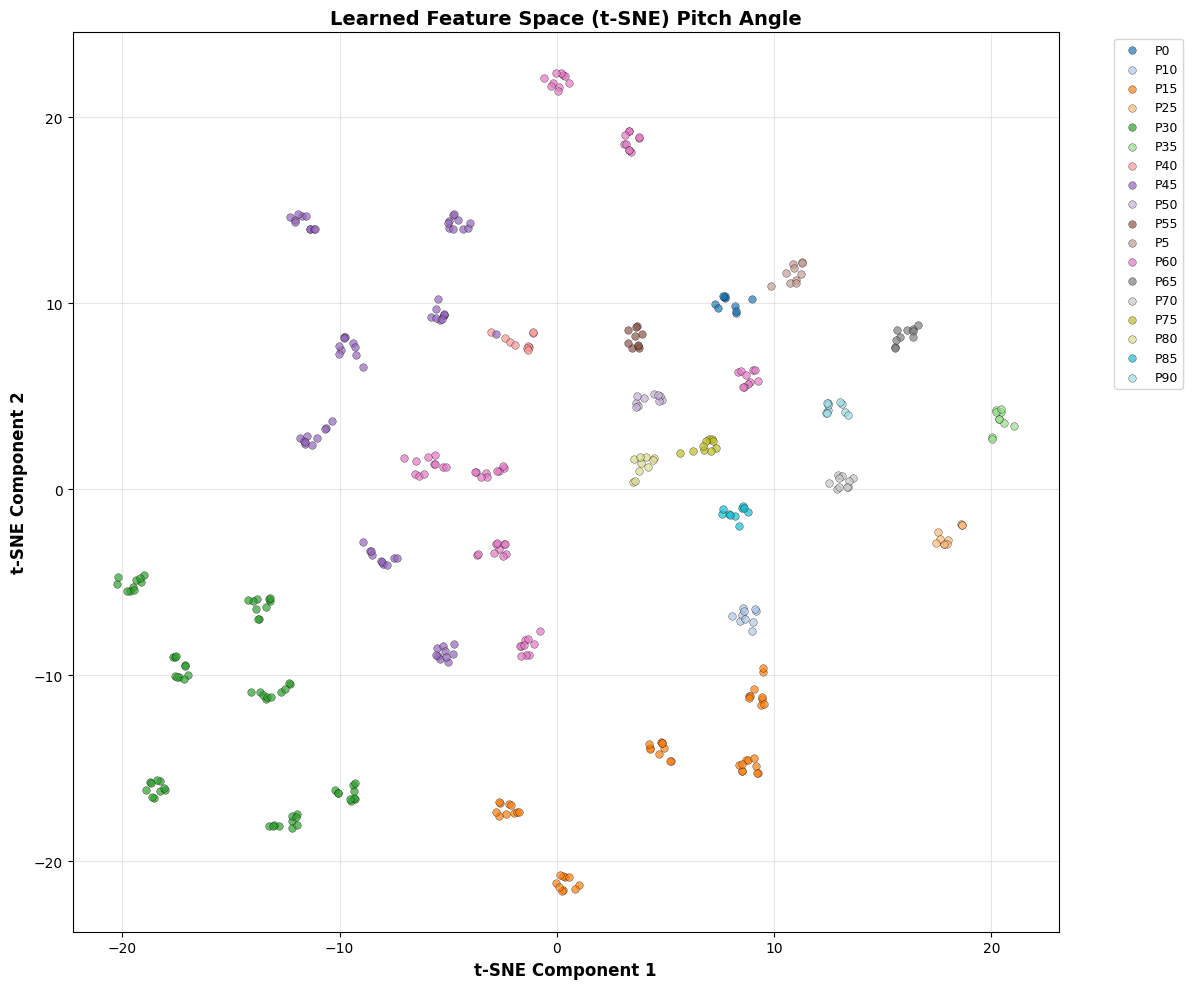

In [20]:
# Extract learned features from the model
import numpy as np

print("Extracting learned feature embeddings...")

baseline_model.eval()
embeddings_list = []
pitch_labels_list = []
roll_labels_list = []

with torch.no_grad():
    for batch_idx, (images, labels_dict) in enumerate(test_loader):
        images = images.to(device)
        
        # Forward pass and get features before classification heads
        pitch_out, roll_out, features = baseline_model(images, return_features=True)
        
        embeddings_list.append(features.cpu().numpy())
        pitch_labels_list.append(labels_dict["pitch"].cpu().numpy())
        roll_labels_list.append(labels_dict["roll"].cpu().numpy())

# Concatenate all batches
embeddings = np.concatenate(embeddings_list, axis=0)
pitch_labels_all = np.concatenate(pitch_labels_list, axis=0)
roll_labels_all = np.concatenate(roll_labels_list, axis=0)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Number of samples: {len(embeddings)}")
print(f"Feature dimension: {embeddings.shape[1]}")

# Use plot_embedding_tsne utility
from src.utils import plot_embedding_tsne

plot_embedding_tsne(
    features=embeddings,
    labels=pitch_labels_all,
    label_names=pitch_names,
    save_path=project_root / 'reports' / '5_swin_v2_tsne_embeddings_pitch.png',
    title='Learned Feature Space (t-SNE) Pitch Angle'
)


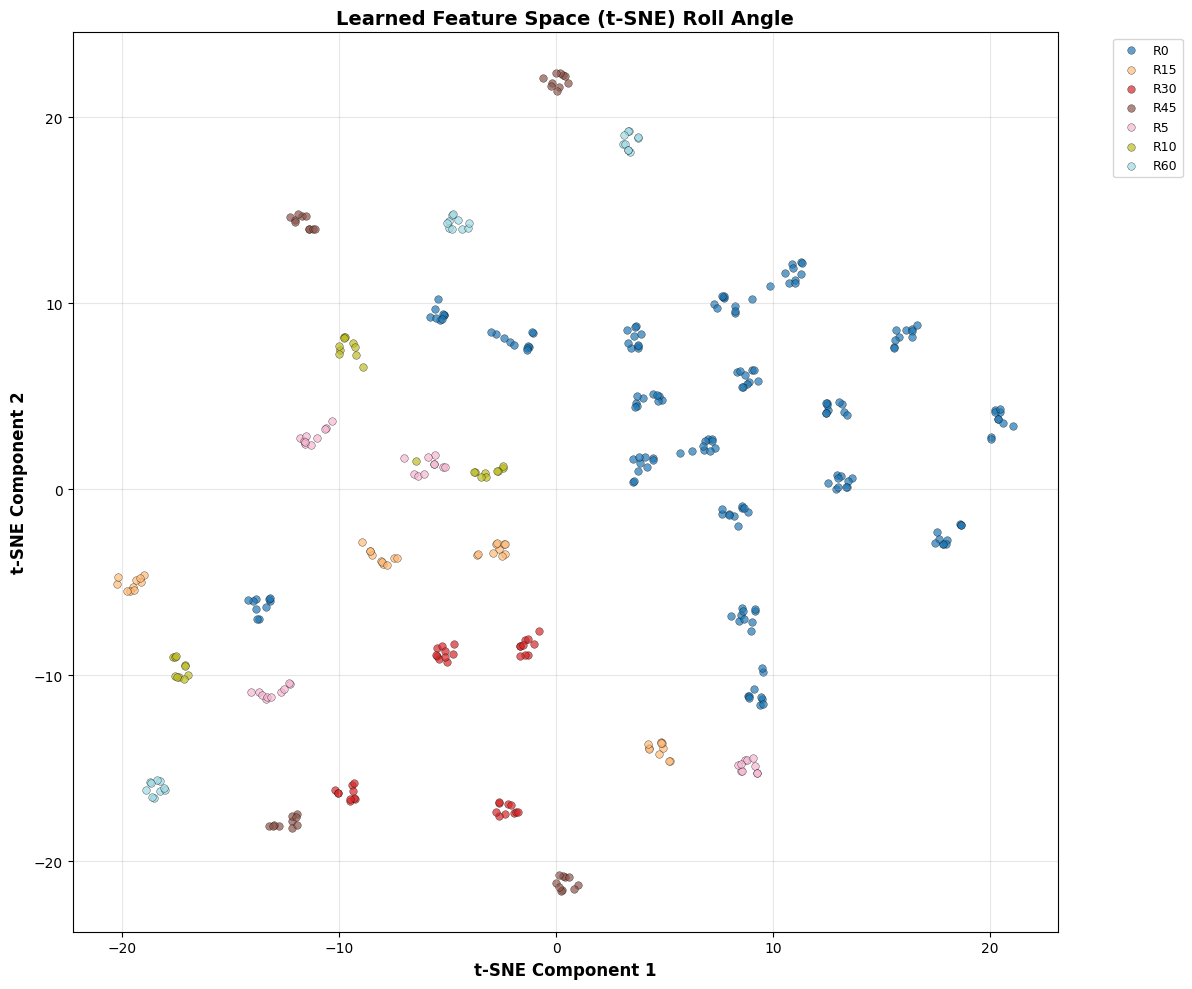

In [21]:
plot_embedding_tsne(
    features=embeddings,
    labels=roll_labels_all,
    label_names=roll_names,
    save_path=project_root / 'reports' / '5_swin_v2_tsne_embeddings_roll.png',
    title='Learned Feature Space (t-SNE) Roll Angle'
)


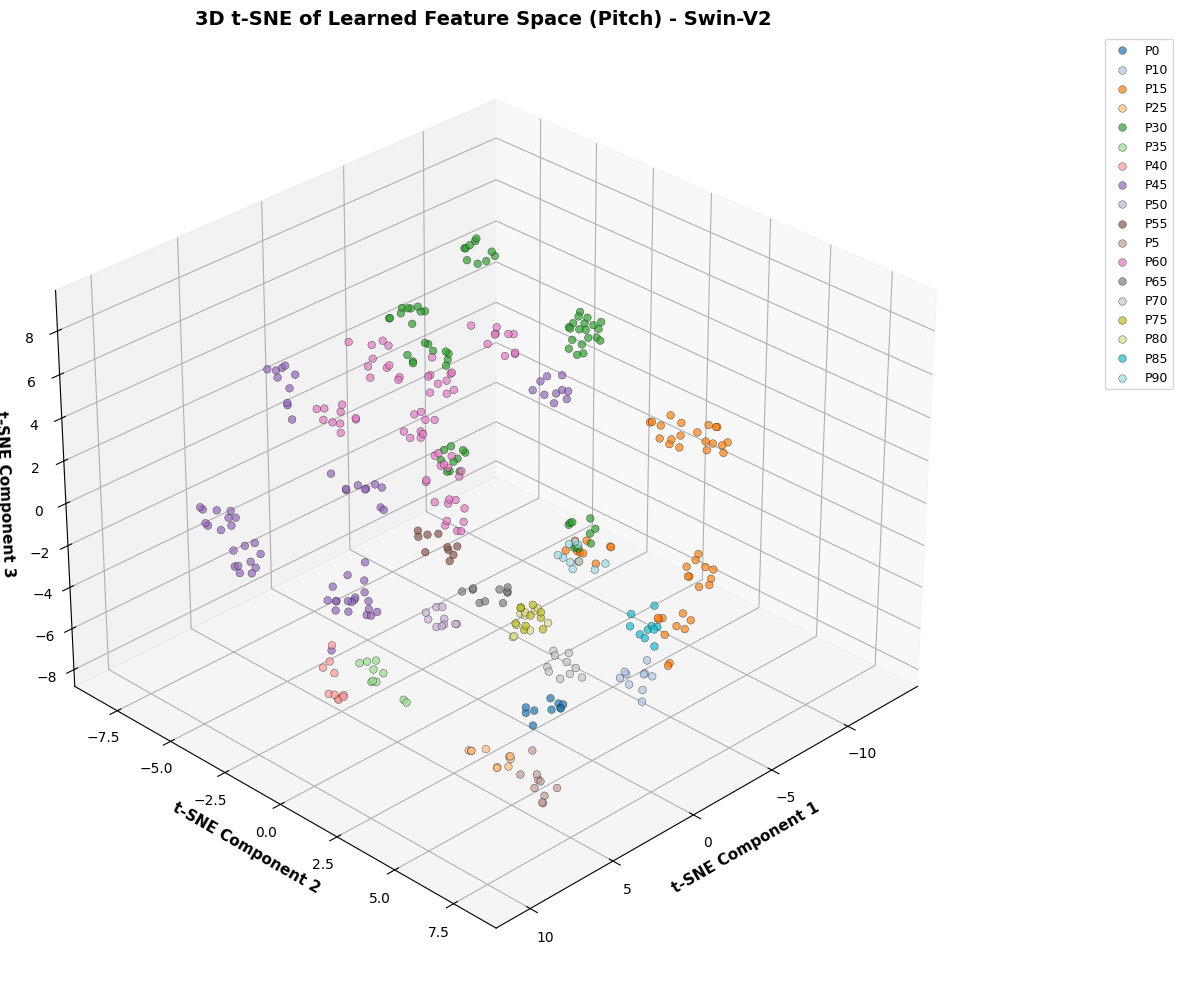


📍 3D t-SNE visualization created (Pitch)


In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # activates 3D projection
import numpy as np

# --- Compute 3D t-SNE ---
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
features_3d = tsne.fit_transform(embeddings)

# --- Plot ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

unique_pitch_labels_all = np.unique(pitch_labels_all)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_pitch_labels_all)))

for label, color in zip(unique_pitch_labels_all, colors):
    mask = pitch_labels_all == label
    ax.scatter(
        features_3d[mask, 0],
        features_3d[mask, 1],
        features_3d[mask, 2],
        c=[color],
        label=pitch_names[label] if label < len(pitch_names) else f'Class {label}',
        alpha=0.7,
        s=30,
        edgecolors='k',
        linewidth=0.3
    )

# --- Labels ---
ax.set_xlabel('t-SNE Component 1', fontweight='bold', fontsize=11)
ax.set_ylabel('t-SNE Component 2', fontweight='bold', fontsize=11)
ax.set_zlabel('t-SNE Component 3', fontweight='bold', fontsize=11)

ax.set_title('3D t-SNE of Learned Feature Space (Pitch) - Swin-V2', fontsize=14, fontweight='bold')
ax.view_init(elev=30, azim=45)
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()

if project_root / 'reports' / '5_swin_v2_tsne_3d_pitch.png':
    plt.savefig(project_root / 'reports' / '5_swin_v2_tsne_3d_pitch.png', dpi=200, bbox_inches='tight')

plt.show()

print("\n📍 3D t-SNE visualization created (Pitch)")


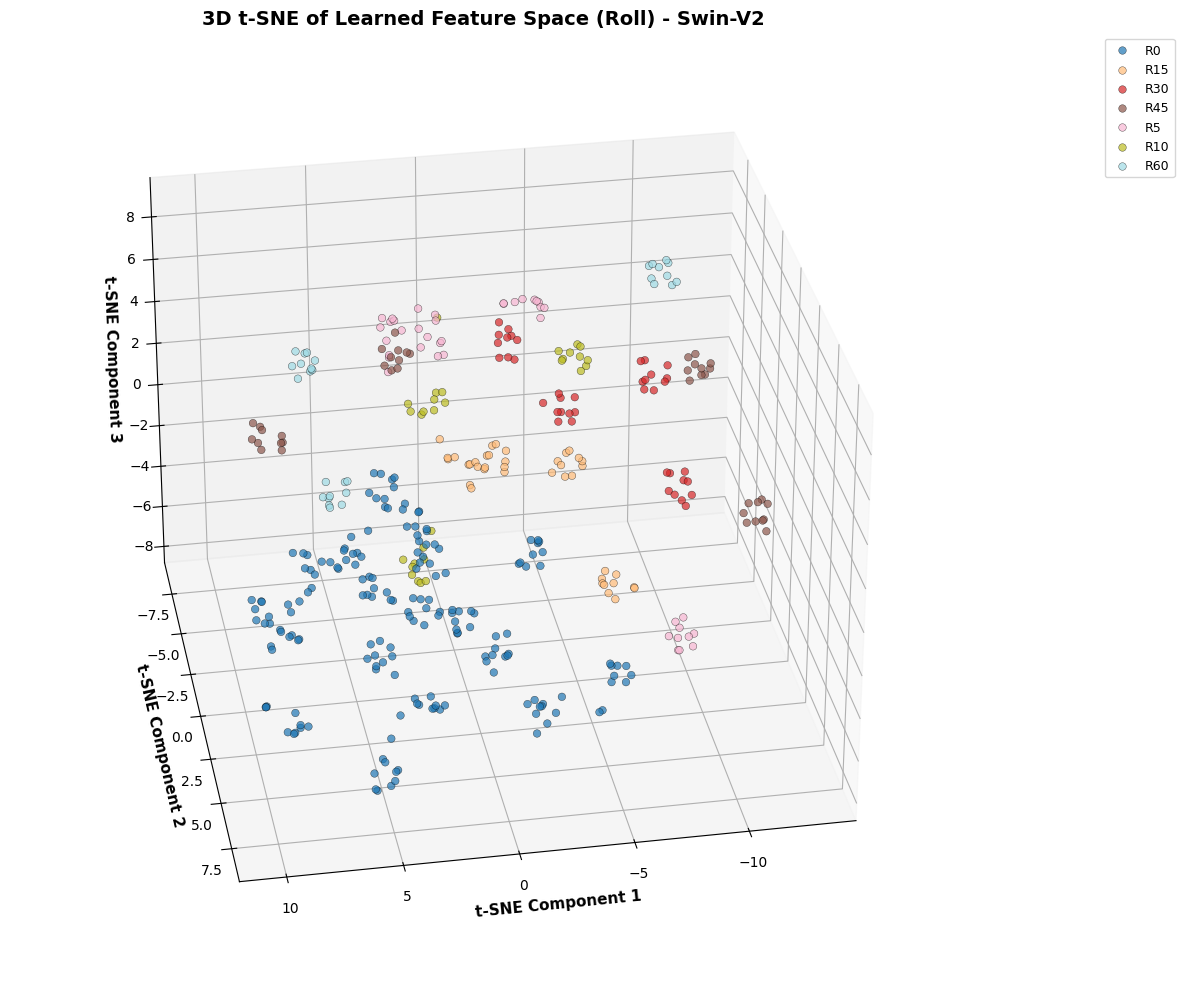


📍 3D t-SNE visualization created (Roll)


In [23]:

tsne = TSNE(n_components=3, random_state=42, perplexity=30)
features_3d = tsne.fit_transform(embeddings)

# --- Plot ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

unique_roll_labels_all = np.unique(roll_labels_all)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_roll_labels_all)))

for label, color in zip(unique_roll_labels_all, colors):
    mask = roll_labels_all == label
    ax.scatter(
        features_3d[mask, 0],
        features_3d[mask, 1],
        features_3d[mask, 2],
        c=[color],
        label=roll_names[label] if label < len(roll_names) else f'Class {label}',
        alpha=0.7,
        s=30,
        edgecolors='k',
        linewidth=0.3
    )

# --- Labels ---
ax.set_xlabel('t-SNE Component 1', fontweight='bold', fontsize=11)
ax.set_ylabel('t-SNE Component 2', fontweight='bold', fontsize=11)
ax.set_zlabel('t-SNE Component 3', fontweight='bold', fontsize=11)

ax.set_title('3D t-SNE of Learned Feature Space (Roll) - Swin-V2', fontsize=14, fontweight='bold')
ax.view_init(elev=30, azim=80)
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()

if project_root / 'reports' / '5_swin_v2_tsne_3d_roll.png':
    plt.savefig(project_root / 'reports' / '5_swin_v2_tsne_3d_roll.png', dpi=200, bbox_inches='tight')

plt.show()

print("\n📍 3D t-SNE visualization created (Roll)")
